# Requirements

Add the conda-forge software channel, and install (or update) PyEMMA:
```bash
conda config --add channels conda-forge
conda install pyemma
```

# Featurization

Import the [pyEMMA coordinates](http://emma-project.org/latest/api/index_coor.html).
>  This package contains functions and classes for reading and writing trajectory files, extracting order parameters from them (such as distances or angles), as well as various methods for dimensionality reduction and clustering.

In [1]:
import pyemma.coordinates as coor
import numpy as np

In [2]:
#Define our input MD files
md_nc = '4XH_1-md_subsamp.nc'
topfile = '4XH_1-top.pdb'

From the coordinates module, use the [featurizer](http://emma-project.org/latest/api/generated/pyemma.coordinates.featurizer.html#pyemma.coordinates.featurizer) to select the ligand heavy atoms.

In [3]:
feat = coor.featurizer(topfile)
lig_atoms = feat.select("resname LIG and not type H")
feat.add_selection(lig_atoms)
print('Selected %s heavy atoms' % len(lig_atoms))

Selected 11 heavy atoms


Load the coordinates from disc. Often, coordinates will not fit into memory, so we'll just create a loader by specifying the files as follows using the [source module](http://emma-project.org/latest/api/generated/pyemma.coordinates.source.html):

In [4]:
inp = coor.source(md_nc, feat)
print('number of trajectories = ',inp.number_of_trajectories())
print('trajectory length = ',inp.trajectory_length(0))
print('number of dimension = ',inp.dimension())

number of trajectories =  1
trajectory length =  750
number of dimension =  33


# Dimensionality Reduction
## time-lagged independent component analysis (TICA)
[TICA theory](http://docs.markovmodel.org/lecture_tica.html)

Run TICA for a series of lag times and select a suitable lag time for further analysis. In order to do so, have a look at the implied timescales generated by TICA. The [TICA object](http://emma-project.org/latest/api/generated/pyemma.coordinates.tica.html#pyemma.coordinates.tica) has an attribute timescales.



In [5]:
#Frames in MD simulation were taken every 10ps 
#Give a range of different lag times to try out
dt = 10
lag_list = np.arange(1, 20,5)
nlags = lag_list.shape[0]

In [6]:
#Load the trajectory files
Y = inp.get_output()
print("type of Y:", type(Y))
print("length of Y:", len(Y))
print("shape of first element:", Y[0].shape)

type of Y: <class 'list'>
length of Y: 1
shape of first element: (750, 33)


The installed widget Javascript is the wrong version.


In [7]:
#Try out different lag times fr 
lag_times = []
for lag in lag_list:
    data = coor.tica(np.vstack(Y),lag, kinetic_map=True, var_cutoff=0.95, reversible=True)
    lag_times.append(data.timescales[:10])
lag_times = np.asarray(lag_times)

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0,0.5,'Timescales [$ps$]')

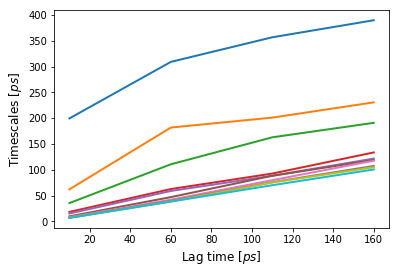

In [9]:
#Plot the different lag times
plt.plot(dt*lag_list, dt*lag_times, linewidth=2)
plt.xlabel(r"Lag time [$ps$]", fontsize=12)
plt.ylabel(r"Timescales [$ps$]", fontsize=12)

In [10]:
#Select a lag time where the lines start to level off
#Here, I'll use 80ps
lag = np.int(80/ dt)
tica_obj = coor.tica(inp, lag=lag, kinetic_map=True, var_cutoff=0.95, reversible=True)
print('TICA dimension ', tica_obj.dimension())

TICA dimension  17


The installed widget Javascript is the wrong version.


Plot the first two TICA components. The TICA object has a get_output() method.

In [11]:
Y = tica_obj.get_output() # get tica coordinates
print('number of trajectories = ', np.shape(Y)[0])
print('number of frames = ', np.shape(Y)[1])
print('number of dimensions = ',np.shape(Y)[2])

The installed widget Javascript is the wrong version.


number of trajectories =  1
number of frames =  750
number of dimensions =  17


PyEMMA has a [plotting module](http://emma-project.org/latest/api/index_plots.html#plots-plotting-tools-pyemma-plots) which we can use to plot the TICA coordinates

In [12]:
from pyemma import plots

//anaconda/envs/bluesdev/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0,0.5,'TIC 2')

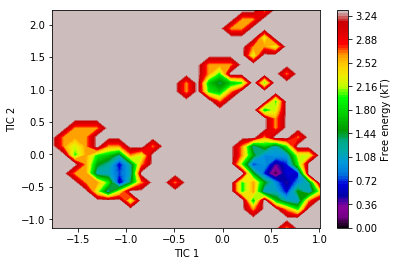

In [13]:
plots.plot_free_energy(np.vstack(Y)[:, 0], np.vstack(Y)[:, 1], nbins=25)
plt.xlabel('TIC 1')
plt.ylabel('TIC 2')

# Clustering the data

## K-means clustering
Use [k-means clustering](http://emma-project.org/latest/api/generated/pyemma.coordinates.clustering.KmeansClustering.html#pyemma.coordinates.clustering.KmeansClustering) and get the discrete trajectories

In [14]:
cl = coor.cluster_kmeans(data=np.vstack(Y), max_iter=100)
# for later use we save the discrete trajectories and cluster center coordinates:
dtrajs = cl.dtrajs
cc_x = cl.clustercenters[:, 0]
cc_y = cl.clustercenters[:, 1]

10-11-17 15:52:10 pyemma.coordinates.clustering.kmeans.KmeansClustering[11] INFO     The number of cluster centers was not specified, using min(sqrt(N), 5000)=27 as n_clusters.
10-11-17 15:52:10 pyemma.coordinates.clustering.kmeans.KmeansClustering[11] INFO     Cluster centers converged after 10 steps.


The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


Visualize the clusters

//anaconda/envs/bluesdev/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0,0.5,'TIC 2')

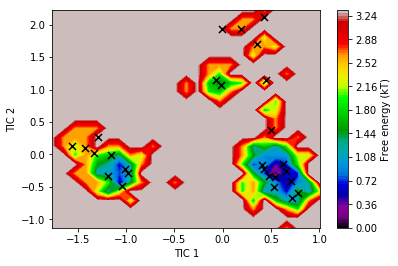

In [15]:
plots.plot_free_energy(np.vstack(Y)[:, 0], np.vstack(Y)[:, 1], nbins=25)
plt.scatter(cc_x, cc_y, marker = 'x', s=50,color = 'black')
plt.xlabel('TIC 1')
plt.ylabel('TIC 2')

If you have time, try other clustering methods (regular space, regular time) and visualize the results. Which method do you prefer?

# Markov State Model construction
#### Theory: 
- [Implied timescales](http://docs.markovmodel.org/lecture_implied_timescales.html)
- Pande, V. S., K. A. Beauchamp, and G. R. Bowman. [Everything you wanted to know about Markov State Models but were afraid to ask](http://www.sciencedirect.com/science/article/pii/S1046202310001568?via%3Dihub)
 Methods 52.1 (2010): 99-105
Let's estimate MSMs at different lagtimes. Now we would like the lagtime to converge within the statistical uncertainty.

This function estimates an MSM for each of the lag-times we have provided: $\tau=n_{lag}\cdot t_{\text{stride}}$ Where $n_{lag}$ is one of the integers given in the lags list, and  $t_{\text{stride}}$ is the trajectory time-stride. For the example data given here the last parameter is $80\,\mathrm{ps}$. The implied-timescales are then computed as:
   $$ t_i = \frac{-\tau}{\ln | \lambda_i(\tau) |}.$$
The its object contains these implied time-scales which can be plotted using one of PyEMMAs built in function for quick inspection - here you can also defined the time-units to ensure the axes express physical time.

In [16]:
from pyemma import msm

In [17]:
print(lag)
its = msm.timescales_msm(dtrajs, lags=lag, nits=10)

8


The installed widget Javascript is the wrong version.


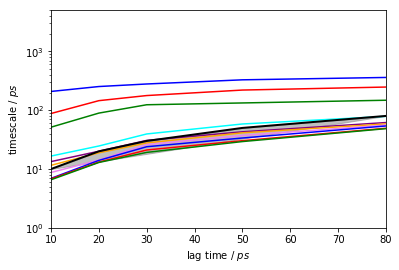

In [18]:
plots.plot_implied_timescales(its,dt=dt, units='$ps$')
plt.ylim(1,5000);

Use plots.plot_implied_timescales to visualize.

It has been shown that the implied timescales (y-axis) should be independent of the lag time (x-axis) [3]. For short lag times this is not the case, but after about 40 picoseconds, they are fairly constant. Some of the faster timescales (lower value on y-axis) either still increase as a function of lag-time or fall below the grey shaded area in the plot. This is often the case and is due to a combination of numerical issues and an imperfect discretization - this mean that the processes associated with these time-scales will be unreliable. The grey area defines the lag-time of the model, and therefore also the time-resolution of what can be resolved. If the processess fall within this area, they are generally not resolved.

Basically - we have to make a compromise, we want to have the model which the highest time-resolution which still has implied time-scales which are lag-time independent.

Sometimes it can be useful to quantify the uncertainty of these time-scales, to get a better idea of any changes in the implied-timescales carry any statistical significance. 

**using the docstring of the its-function, try to figure out how to obtain Bayesian error estimates of the implied time-scales**

Estimate uncertainties using Bayesian sampling. Note that these errors tend to be a bit underestimated, but we can still see that the timescales are flat within the error for lag times above 40 picoseconds.

The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


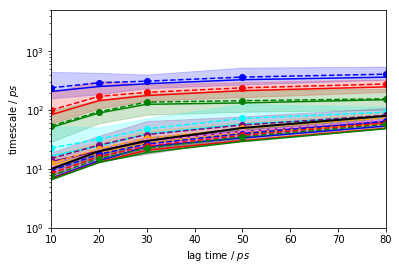

In [19]:
its = msm.timescales_msm(dtrajs, lags=lag, nits=10, errors='bayes')
plots.plot_implied_timescales(its, dt=dt, units='$ps$')
plt.ylim(1, 5000);

Now build an MSM at a good lag time:

In [20]:
M = msm.estimate_markov_model(dtrajs, lag)

In [21]:
#Count of transitions between two states
M.count_matrix_active

array([[  4.,   0.,   1.,   0.,   0.,   4.,   0.,   1.,   4.,   3.,   1.,
          5.,   4.,   1.,   2.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          1.,   0.,   0.,   2.,   2.],
       [  0.,   1.,   0.,   0.,   1.,   0.,   2.,   2.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   6.,   0.,   0.,   0.,
          2.,   0.,   1.,   0.,   0.],
       [  0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   3.,   0.,   0.,   0.,   0.,
          0.,   2.,   0.,   0.,   0.],
       [  0.,   0.,   0.,  12.,   1.,   1.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   4.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   9.,
          0.,   0.,   0.,   0.,   0.],
       [  0.,   1.,   0.,   0.,   3.,   0.,   1.,   4.,   1.,   1.,   1.,
          0.,   1.,   0.,   1.,   1.,   0.,   0.,   6.,   3.,   0.,   0.,
          4.,   0.,   0.,   0.,   0.],
       [  7.,   1.,   0.,   0.,   0.,   8.,   8.,   1.,   5.,   1

## Validation - Chapman-Kolmogorov test

Let's see if our Markov model fulfill the Chapman-Kolmogorov equation. This is a way of testing the self-consistency of the model. There will be more background this tomorrow morning.

The MSM instance has a method to make the testing very easy:

In [22]:
ckt = M.cktest(3)

The installed widget Javascript is the wrong version.


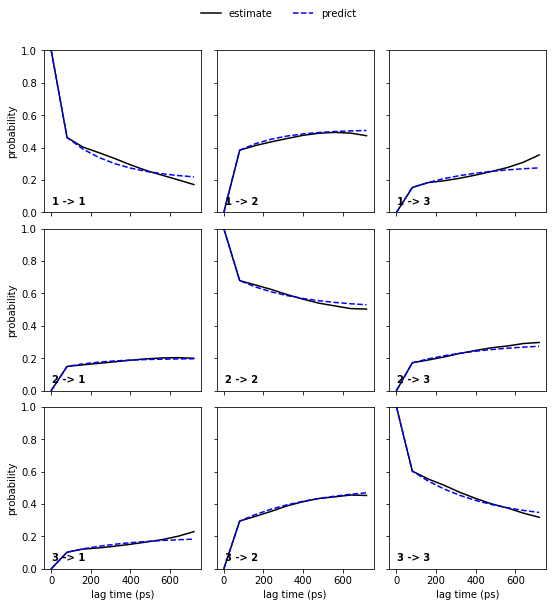

In [23]:
plots.plot_cktest(ckt,dt=dt,units="ps");

What is shown here is the predicted transition probabilities from the Markov model (blue) and corresponding ones estimated directly from the data you used to estimate the Markov model (that is, training a Markov model with a larger lag-time). More formally what we check is whether the following relation is approximately fulfilled:
$$ \underbrace{T^k(\tau)}_{\text{Markov model prediction}} \approx \underbrace{T(k\tau)}_{\text{estimation from data}} $$
where $k$ is some positive integer, and $T(\cdot)$ is a transition probability matrix for a given lag-time. Basically, we want to ensure these lines are as close as possible to each other. More depth on this topic is given tomorrow morning.


## Spectral analysis


Let us have a closer look at the timescales that were already seen in the its plot:

(-0.5, 10.5)

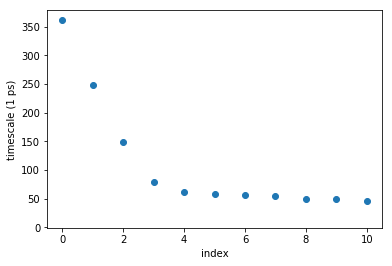

In [24]:
plt.plot(dt*M.timescales(),linewidth=0,marker='o')
plt.xlabel('index');plt.ylabel(r'timescale (1 ps)'); plt.xlim(-0.5,10.5)

## PCCA

#### Theory
- [PCCA: perron-cluster cluster analysis](http://docs.markovmodel.org/lecture_pcca.html)

Select a suitable number of metastable states and run PCCA.

In [25]:
n_clusters = 3
M.pcca(n_clusters)

Visualize the PCCA assignments in the free energy landscape defined by the first two TICA coordinates.
Hints: A Markov model object has an attribute M.metastable_sets. Also, you need to find out how to access the clustercenters defined in the previous step.

//anaconda/envs/bluesdev/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0,0.5,'TIC 2')

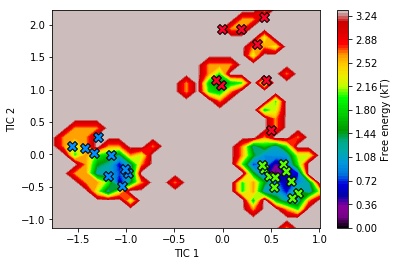

In [26]:
_, ax = plots.plot_free_energy(np.vstack(Y)[:, 0], np.vstack(Y)[:, 1], nbins=25)
pcca_sets = M.metastable_sets

cm = plt.get_cmap('gist_rainbow')
colors = [cm(1.*i/n_clusters) for i in range(n_clusters)]

for i, color in enumerate(colors[:n_clusters]):
    ax.scatter(cl.clustercenters[pcca_sets[i],0], cl.clustercenters[pcca_sets[i],1], marker='X', c=color,s=100, edgecolors='k')
ax.set_xlabel('TIC 1')
ax.set_ylabel('TIC 2')
#plt.savefig('4XH_1_c0-tiCA-PCCA.png', dpi=300,bbox_inches='tight')

### Extracting the PCCA cluster frames

In [27]:
import mdtraj as md

In [28]:
#Create an mdtraj.Trajectory object to extract frames from
pdb = md.load(topfile)
ctraj = md.load(md_nc,top=pdb.top)
print(ctraj)

<mdtraj.Trajectory with 750 frames, 5132 atoms, 323 residues, and unitcells>


In [29]:
# Store the set of PCCA frames into a dictionary
pcca_traj = {}
for n in range(n_clusters):
    frames = cl.index_clusters[pcca_sets[n]][0][:,1]
    pcca_traj[n] = ctraj[frames]
pcca_traj

{0: <mdtraj.Trajectory with 6 frames, 5132 atoms, 323 residues, and unitcells at 0x1191704a8>,
 1: <mdtraj.Trajectory with 37 frames, 5132 atoms, 323 residues, and unitcells at 0x12021fba8>,
 2: <mdtraj.Trajectory with 16 frames, 5132 atoms, 323 residues, and unitcells at 0x1205382e8>}

## Assigning frames by RMSD to PCCA clusters

In [30]:
import sys
def drawProgressBar(percent, barLen = 20):
    """Helper function that prints a progress bar for loops."""
    sys.stdout.write("\r")
    progress = ""
    for i in range(barLen):
        if i < int(barLen * percent):
            progress += "="
        else:
            progress += " "
    sys.stdout.write("[ %s ] %.2f%%" % (progress, percent * 100))
    sys.stdout.flush()

In [31]:
def rmsdNP(traj, ref, idx):
    """Compute the RMSD wihtout trajectory alignment
    
    Parameters:
    - traj : mdtraj.Trajectory 
    - ref  : mdtraj.Trajectory  
            reference trajectory to compare `traj` object
    - idx  : list of atom inidices
    """
    return np.sqrt(3*np.sum(np.square(traj.xyz[:,idx,:] - ref.xyz[:,idx,:]),
                          axis=(1, 2))/idx.shape[0])

In [32]:
def assignFramesFromPCCALeaders(traj, pcca_traj,n_clusters=4, 
                                n_leaders_per_cluster=3,
                                selection='resname LIG and not type H'):
    """Function that will assign each trajectory frame to each PCCA cluster
    by the cluster that minimizes the RMSD of the ligand selection.
    
    Parameters:
    - traj : mdtraj.Trajectory
    - pcca_traj : dict of mdtraj.Trajectory { int : mdtraj.Trajectory }
                  Each key corresponds to the indices of the clusters.
                  Values correspond to the mdtraj.Trajectory extracted from PCCA analysis
                  
    """
    #WorkAround: Can't create a new 'boxless' traj, insert 1 frame from traj[0] into leaders.
    leaders = md.Trajectory(xyz=np.empty((0, traj.n_atoms, 3)), topology=traj.topology)
    leaders = traj[0]
    leader_labels = []
    print('Extracting %s frames for leaders' % n_leaders_per_cluster)
    for n,mtrj in pcca_traj.items():
        leaders = leaders.join(mtrj[np.random.choice(pcca_traj[n].n_frames, n_leaders_per_cluster)])
        leader_labels.extend([n] * n_leaders_per_cluster)
            
    #Cut out the inserted frame dummy frame from the workaround
    leaders = leaders[1:]
        
    print('Assigning trajectory frames by leaders')
    cluster_labels = []
    for i,frame in enumerate(traj):
        rmsds = rmsdNP(leaders,frame,traj.top.select(selection))
        cluster_labels.append(leader_labels[np.argmin(rmsds)])
        drawProgressBar(i/(traj.n_frames-1)) 
    cluster_labels = np.array(cluster_labels)

    return cluster_labels

In [33]:
md_labels = assignFramesFromPCCALeaders(ctraj,pcca_traj,n_clusters=n_clusters)

Extracting 3 frames for leaders
Assigning trajectory frames by leaders
[ ==================== ] 100.00%

# Plotting ligand binding mode sampling with RMSD

In [34]:
def plotPoseSampling(distances,
                     cluster_labels,
                     title="Binding Mode Frequency",
                     acc_it=[], n_clusters=4,
                     cmap='gist_rainbow'):
    """Function that plots the RMSD of the ligand atoms with each frame/data point colored
    according to the cluster assignment.
    
    Parameters:
    - distances : np.array of the desired RMSD to plot
    - cluster_labels : list of the cluster assigments of the trajectory frames
    """
    
    #Define plot settings
    N = len(cluster_labels)
    plt.figure(figsize=(12, 8), dpi=300,tight_layout=True)
    f, ax = plt.subplots(2)
    
    #Get the color mappings for the number of clusters
    cm = plt.get_cmap(cmap)
    colors = [cm(1.*i/n_clusters) for i in range(n_clusters)]

    #Compute and plot the % frequency in bar plot
    labeled_frames = {n:[] for n in range(n_clusters)}
    for i, label in enumerate(cluster_labels):
        labeled_frames[label].append(i)
    freq = { key:len(val)/N*100 for key,val in labeled_frames.items() }
    rect = ax[0].bar(range(len(freq.keys())),freq.values(), align='center', color=colors)
    ax[0].set_xlabel("Ligand Binding Mode")
    ax[0].set_ylabel("% Frequency")
    ax[0].set_xticks([])
    
    #Generate a list of colors corresponding to the cluster assignment 
    colr_list = []
    for x in cluster_labels:
        colr_list.append(colors[x])
    
    #Convert frame numbers to time
    time = [0.2*t for t in range(N)]
    
    #Lineplot of RMSD relative to initial frame
    #Convert distances from nm to angstrom (distances*10.0)
    ax[1].plot(time, 10.0*distances, 'k', linewidth=0.25)
    #Colored Scatterplot points to state of minimum RMSD
    ax[1].scatter(time, 10.0*distances,c=colr_list,clip_on=False,s=25, edgecolors=None)
    
    #With BLUES, plot the vertical lines to indicate the accepted moves
    if acc_it:
        for it in acc_it:
            ax[1].axvline(x=it, color='k', linestyle='--')
            
    #Label axis        
    ax[1].set_xlabel("Time (ns)")
    ax[1].set_ylabel(r"RMSD $\AA$")
    ax[1].xaxis.grid(False)
    ax[1].yaxis.grid(False, which='major')
    plt.autoscale(enable=True, axis='both', tight=True)
    ax[0].set_title(title+" N=%s" %N)

In [35]:
# Compute the RMSD of the ligand heavy atoms relative to the starting frame
md_dist = rmsdNP(ctraj, ctraj[0],ctraj.top.select('resname LIG and not type H'))

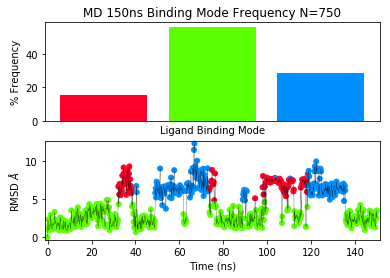

In [36]:
# Plot the frequency of sampling of each binding mode
plotPoseSampling(md_dist,md_labels,n_clusters=n_clusters,
                 title="MD 150ns Binding Mode Frequency")
plt.savefig('4XH_1-bmodes-freq.png', dpi=300, bbox_inches='tight')

# Acknolwedgements

Authors: **Nathan M. Lim**
 - Material adapted from Markov State Modeling workshop at UCSD 2017 hosted by **Frank Noe** and **Rommie Amaro**

 
# References
1. Shaw DE, Maragakis P, Lindorff-Larsen K, Piana S, Dror RO, Eastwood MP, Bank JA, Jumper JM, Salmon JK, Shan Y,
Wriggers W: Atomic-level characterization of the structural dynamics of proteins.
*Science* **330**:341-346 (2010). doi: 10.1126/science.1187409.
2. Molgedey, L. and H. G. Schuster, Phys. Rev. Lett. 72, 3634 (1994).
3. Pérez-Hernández, G. and Paul, F. and Giogino, T. and de Fabritiis, G. and Noé, F. Identification of slow molecular order parameters for Markov model construction. *J. Chem. Phys.* **139**:015102 (2013)
4. Swope WC, Pitera JW and Suits F. Describing protein folding kinetics by molecular dynamics simulations: 1. Theory. 
*J. Phys. Chem. B* **108**:6571-6581 (2004)
5. Röblitz S. and M. Weber: Fuzzy spectral clustering by PCCA+: application to Markov state models and data classification. Adv. Data. Anal. Classif. DOI 10.1007/s11634-013-0134-6 (2013) 
6. Noé F, Doose S, Daidone I, Löllmann M, Chodera JD, Sauer M, Smith JC. Dynamical fingerprints for probing individual relaxation processes in biomolecular dynamics with simulations and kinetic experiments. *Proc. Natl. Acad. Sci. USA*, **108**: 4822-4827 (2011)
7. Metzner P, Schütte C, Vanden-Eijnden, E. Transition Path Theory for Markov Jump Processes. *Multiscale Model. Simul.* **7**. 1192--1219 (2009)
8. Noé F, Schütte C, Vanden-Eijnden E, Reich L and Weikl T. Constructing the Full Ensemble of Folding Pathways from Short Off-Equilibrium Simulations. *Proc. Natl. Acad. Sci. USA*, **106**:19011-19016 (2009)